In [2]:
# Install missing package for imblearn (runs in the notebook environment)
%pip install imbalanced-learn

import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

Note: you may need to restart the kernel to use updated packages.


# Buat Dataset yang akan digunakan

In [3]:
X, y = make_classification(n_samples=1000,
                           n_features=15,
                           n_informative=10,
                           n_redundant=2,
                           n_clusters_per_class=1,
                           weights=[0.9],
                           flip_y=0,
                           random_state=42
                           )

Setelah menjalankan kode di atas, Anda akan memiliki 1000 data dengan 15 fitur independen dan satu fitur dependen yang berbeda-beda. By default, fungsi ini akan membuat dua buah kelas yang berbeda, tetapi Anda juga bisa menentukan jumlah kelas dengan mengatur nilai n_classes, ya. 

Karena pada akhir materi ini kita akan belajar mengenai salah satu metode oversampling, Anda perlu mengatur nilai weights (rasio) untuk membagi jumlah data pada masing-masing kelas. Pada kasus ini, kita akan membagi 90% data untuk kelas pertama, dan 10% data untuk kelas kedua.

Selanjutnya, Anda perlu mengubah nilai acak yang yang tersimpan dengan tipe data array menjadi DataFrame agar lebih mudah diolah dan dicerna oleh orang lain.

In [4]:
# menyusn dataset menjadi DataFrame
df = pd.DataFrame(X, columns=[f'Fitur_{i}' for i in range(1, 16)])
df['Target'] = y

# Misalkan kita punya beberapa fitur kategorikal (simulasi fitur kategorikal)
df['Fitur_12'] = np.random.choice(['A', 'B', 'C'], size=1000)
df['Fitur_13'] = np.random.choice(['X', 'Y', 'Z'], size=1000)
 
df

,Fitur_1,Fitur_2,Fitur_3,Fitur_4,Fitur_5,Fitur_6,Fitur_7,Fitur_8,Fitur_9,Fitur_10,Fitur_11,Fitur_12,Fitur_13,Fitur_14,Fitur_15,Target
0,0.093303,-3.472520,-1.314199,3.525743,0.642138,2.247328,3.067502,1.146301,-2.173112,2.765828,-1.821258,B,Y,1.005559,-0.276558,0
1,-0.189574,-1.770842,-1.578851,-1.372201,-2.025230,0.518655,-0.764750,-3.958705,-0.598147,1.018789,4.194233,C,Y,-0.243630,0.285979,0
2,0.916269,-2.051770,3.631998,0.824844,1.674093,-0.436273,-0.460407,0.031633,-1.140149,2.069694,1.935251,A,X,2.486020,-2.867291,0
3,-0.914665,-1.608657,-0.735184,-1.742743,-1.753532,0.383412,-1.057937,-2.897416,-0.830328,1.572469,5.334621,B,Z,-0.788215,1.255376,0
4,-0.756784,-2.362885,-3.909120,-0.474571,-4.029843,0.947114,0.581146,-3.435229,-2.142380,2.332385,3.816539,A,X,0.712335,2.810524,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-1.927482,-0.017325,4.884411,0.542628,3.033376,-1.904407,0.953035,1.278882,-1.293396,1.772169,-1.191263,C,Y,-0.387151,-2.629004,0
996,0.347761,-1.690916,5.949207,-2.289729,2.238469,-0.067922,-0.069702,-1.436622,-2.153011,-0.867583,3.962758,C,Z,0.886822,-1.248408,0
997,1.201967,-1.263417,-1.331925,-2.468434,1.777577,2.270456,-0.431749,-1.846263,1.753033,1.858452,4.264568,A,Y,0.067260,0.931995,1
998,-2.127846,-0.975838,0.279144,0.151578,-0.443749,0.650616,-1.410265,-1.017319,-0.643070,2.142898,3.399255,A,Y,-0.128774,0.800834,0


Selanjutnya, Anda perlu memisahkan fitur independen dan dependen untuk mempermudah proses feature engineering yang akan dilakukan.

In [5]:
# memisahkan fitur dan target
X = df.drop('Target', axis=1)
y = df['Target']

Saat ini, Anda sudah memiliki sebuah dataset yang siap untuk digunakan pada proses feature engineering. Untuk memastikan proporsi data yang ada, silakan cek menggunakan kode berikut.

In [6]:
# Melihat distribusi kelas
print("Distribusi kelas sebelum SMOTE:", Counter(y))

Distribusi kelas sebelum SMOTE: Counter({0: 901, 1: 99})


Karena dataset ini memiliki fitur yang cukup banyak, pilihlah fitur (feature selection). Anda dapat menggunakan berbagai macam teknik feature selection yang sebelumnya sudah dipelajari pada materi feature selection. Namun, pada latihan ini mari kita gunakan teknik embedded agar terbiasa dengan teknik yang paling kompleks.

In [7]:
# Menggunakan Random Forest Untuk mendapatakan fitur penting
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
X_integer = X.drop(['Fitur_12', 'Fitur_13'], axis=1)  # Menghapus fitur kategorikal untuk Random Forest
rf_model.fit(X_integer, y)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [8]:
# Mendapatkan Fitur Penting
importances = rf_model.feature_importances_
indicies = np.argsort(importances)[::-1]

In [9]:
# menentukan ambang batas untuk fitur penting
threshold = 0.05 # misalnya, ambang batas 5%
important_features_indices = [i for i in range(len(importances)) if importances[i] >= threshold]


In [10]:
# Menampilkan fitur penting beserta nilainya
print("Fitur yang dipilih dengan Embedded Method (diatas ambang batas):")
for i in important_features_indices:
    # Jika nilai x asli berbentuk dataframe, gunakan .columns untuk mendapatkan nama kolom
    print(f"{X_integer.columns[i]}: {importances[i]}")

Fitur yang dipilih dengan Embedded Method (diatas ambang batas):
Fitur_2: 0.11860019897866206
Fitur_3: 0.06878603593465271
Fitur_5: 0.07731131335837178
Fitur_8: 0.050482655781999855
Fitur_9: 0.2625049418105367
Fitur_10: 0.08958259568334655
Fitur_11: 0.06365230544114515
Fitur_15: 0.12578161860669113


In [11]:
# Mendapatkan nama kolom penting berdasarkan Importance
important_features = X_integer.columns[important_features_indices]

# Memindahkan fitur penting ke variabel baru
X_important = X_integer[important_features] # Hanya fitur penting dari data pelatihan

# X_important sekarang berisi hanya fitur-fitur yang dipilih berdasarkan metode Embedded
print("\nDimensi data pelatihan dengan fitur penting:", X_important.shape)


Dimensi data pelatihan dengan fitur penting: (1000, 8)


Kode di atas memiliki karakteristik yang sangat mirip dengan contoh kode pada materi feature selection. Di sini, kita menentukan ambang batas hubungan antara variabel sebesar 5% sehingga mendapatkan delapan fitur dengan tipe data numerik. Eiitts, jika Anda penasaran terkait penjelasan kode di atas secara lebih detail, silakan ulas kembali materi feature selection, ya. 

Lalu, bagaimana dengan nasib data yang bertipe kategorikal? Tenang, kita tidak akan melupakan mereka. Setelah proses pemilihan fitur numerik dilakukan, Anda perlu menggabungkan data numerik dan kategorikal seperti semula.

In [12]:
X_selected = pd.concat([X_important, X['Fitur_12']], axis=1)
X_Selected = pd.concat([X_selected, X['Fitur_13']], axis=1)
X_Selected          

,Fitur_2,Fitur_3,Fitur_5,Fitur_8,Fitur_9,Fitur_10,Fitur_11,Fitur_15,Fitur_12,Fitur_13
0,-3.472520,-1.314199,0.642138,1.146301,-2.173112,2.765828,-1.821258,-0.276558,B,Y
1,-1.770842,-1.578851,-2.025230,-3.958705,-0.598147,1.018789,4.194233,0.285979,C,Y
2,-2.051770,3.631998,1.674093,0.031633,-1.140149,2.069694,1.935251,-2.867291,A,X
3,-1.608657,-0.735184,-1.753532,-2.897416,-0.830328,1.572469,5.334621,1.255376,B,Z
4,-2.362885,-3.909120,-4.029843,-3.435229,-2.142380,2.332385,3.816539,2.810524,A,X
...,...,...,...,...,...,...,...,...,...,...
995,-0.017325,4.884411,3.033376,1.278882,-1.293396,1.772169,-1.191263,-2.629004,C,Y
996,-1.690916,5.949207,2.238469,-1.436622,-2.153011,-0.867583,3.962758,-1.248408,C,Z
997,-1.263417,-1.331925,1.777577,-1.846263,1.753033,1.858452,4.264568,0.931995,A,Y
998,-0.975838,0.279144,-0.443749,-1.017319,-0.643070,2.142898,3.399255,0.800834,A,Y


Waiit, apakah Anda menyadari keanehan dari output di atas? Yup, masih terdapat data kategorikal pada dataset di atas. Apakah itu sebuah masalah? Jelas itu sebuah masalah. karena seperti yang sudah Anda pelajari di awal kelas ini bahwa machine learning tidak menerima input berupa kategorikal atau string. 

Untuk menyelesaikan permasalahan tersebut, Anda dapat melakukan encoding terhadap fitur dengan tipe data kategorikal. Pada latihan ini, mari kita gunakan Label Encoding karena berasumsi bahwa kategori yang ada memiliki urutan yang logis (hal ini karena kita menggunakan dummy dataset).

In [13]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()


In [15]:
# Melakukan Encoding fitur 12
X_Selected['Fitur_12'] = label_encoder.fit_transform(X_Selected['Fitur_12'])
# print(label_encoder.inverse_transform(X_Selected[['Fitur_12']]))

# Melakukan Encoding untuk fitur 13
X_Selected['Fitur_13'] = label_encoder.fit_transform(X_Selected['Fitur_13'])
# print(label_encoder.inverse_transform(X_Selected[['Fitur_13']]))

print(X_Selected)

      Fitur_2   Fitur_3   Fitur_5   Fitur_8   Fitur_9  Fitur_10  Fitur_11  \
0   -3.472520 -1.314199  0.642138  1.146301 -2.173112  2.765828 -1.821258   
1   -1.770842 -1.578851 -2.025230 -3.958705 -0.598147  1.018789  4.194233   
2   -2.051770  3.631998  1.674093  0.031633 -1.140149  2.069694  1.935251   
3   -1.608657 -0.735184 -1.753532 -2.897416 -0.830328  1.572469  5.334621   
4   -2.362885 -3.909120 -4.029843 -3.435229 -2.142380  2.332385  3.816539   
..        ...       ...       ...       ...       ...       ...       ...   
995 -0.017325  4.884411  3.033376  1.278882 -1.293396  1.772169 -1.191263   
996 -1.690916  5.949207  2.238469 -1.436622 -2.153011 -0.867583  3.962758   
997 -1.263417 -1.331925  1.777577 -1.846263  1.753033  1.858452  4.264568   
998 -0.975838  0.279144 -0.443749 -1.017319 -0.643070  2.142898  3.399255   
999  1.387667 -5.554578 -2.834755 -1.932864  2.625895  0.246120  0.786726   

     Fitur_15  Fitur_12  Fitur_13  
0   -0.276558         1         1  
1  

Sampai di sini, semua fitur yang Anda miliki sudah bertipe integer atau numerik. Dengan kondisi seperti ini, dataset yang Anda gunakan sebenarnya sudah siap untuk dilatih. Namun, sebelum melatih dataset tersebut, alangkah baiknya Anda melakukan pengecekan outlier agar model yang dibangun memiliki performa optimal. 

Agar lebih terbayang proses pembelajaran ini, salinlah terlebih dahulu dataset yang akan digunakan sebelum mengubahnya. Tujuannya agar Anda dapat membandingkan karakteristik sebelum dan sesudah menangani outlier. Pertama-tama, mari kita mulai dengan menyalin dataset dan menghapus Fitur_12 dan Fitur_13 yang merupakan data hasil encoding.

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Memlilih Kolom Numerik
numeric_columns = X_Selected.select_dtypes(include=['float64', 'int64']).columns
numeric_columns = numeric_columns.drop(['Fitur_12', 'Fitur_13'])  # Menghapus fitur kategorikal jika ada

# Membuat salinan data
X_cleaned = X_Selected.copy()

Selanjutnya, mari kita deteksi outlier dengan menggunakan visualisasi data BoxPlot. Dengan menggunakan visualisasi, Anda tidak perlu memberikan effort yang besar kepada otak (beban kognitif) karena pada dasarnya hanya dengan melihat visualisasi Anda sudah dapat mendeteksi outliers.

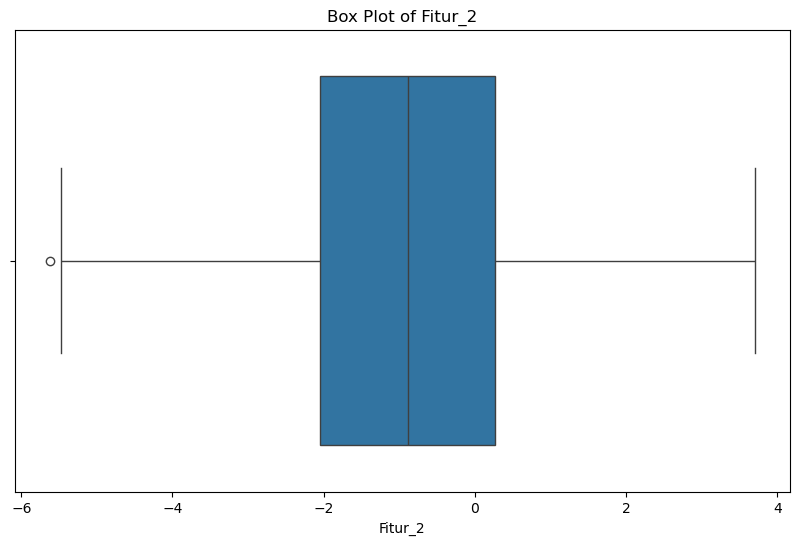

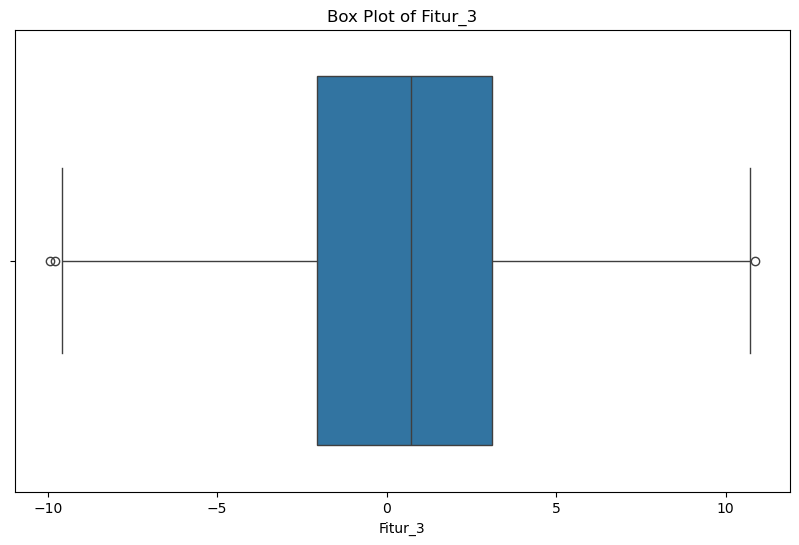

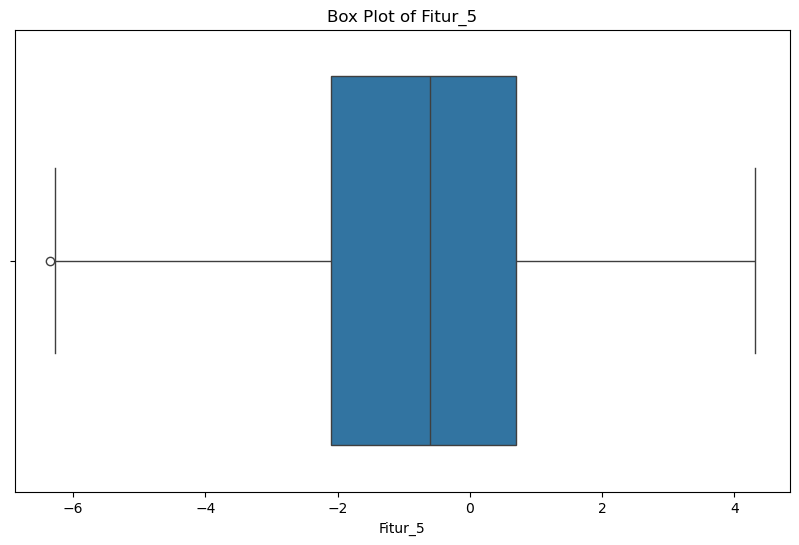

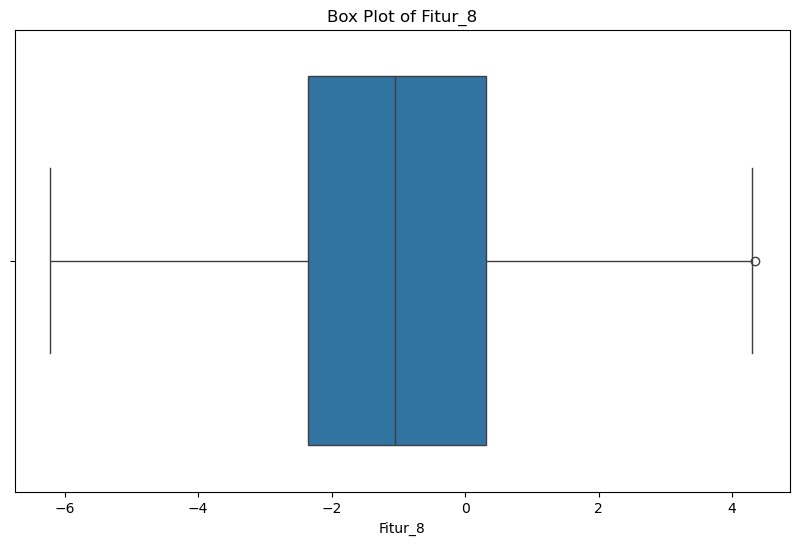

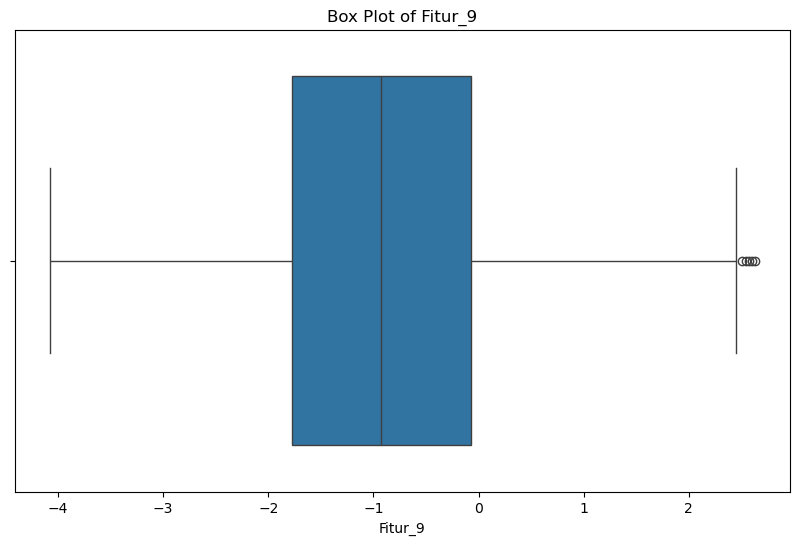

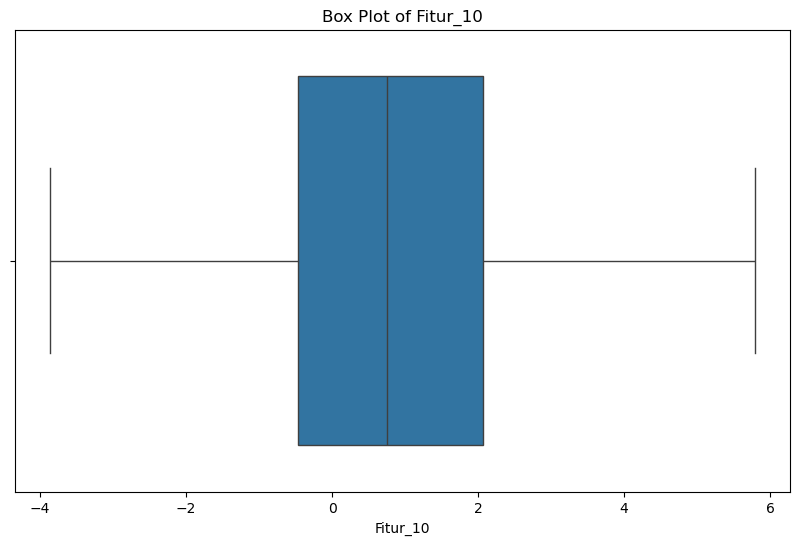

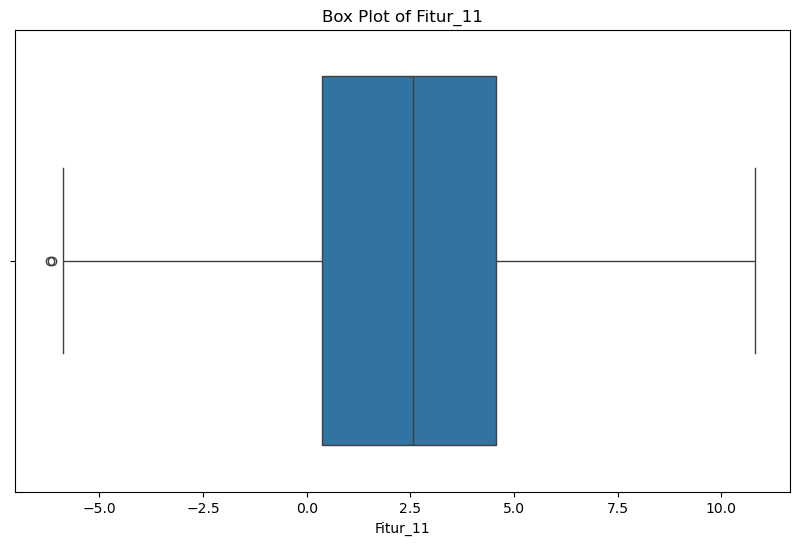

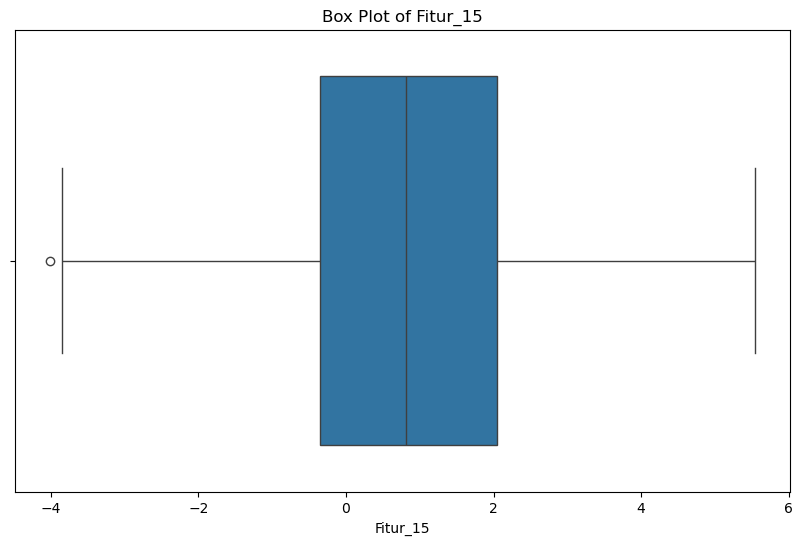

In [35]:
for feature in numeric_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=X_cleaned[feature])
    plt.title(f'Box Plot of {feature}')
    plt.show()

Seperti yang dapat dilihat pada visualisasi di atas, secara langsung dapat disimpulkan bahwa terdapat beberapa nilai outlier pada Fitur_8. Untuk melihat data lengkapnya, silakan ikuti dan jalankan kodenya secara mandiri karena output yang dihasilkan berupa gambar yang cukup besar.

Masih ingatkah Anda bagaimana cara mengatasi outlier pada materi sebelumnya? Benar, salah satu caranya adalah menggunakan teknik interquartile range (IQR). Teknik ini akan mencari nilai batas bawah dan batas atas sehingga Anda dapat menghapus nilai yang berada di luar jangkauan.

In [23]:
for col in numeric_columns:
    # Melihat outlier dengan IQR (Interquartile Range)
    Q1 = X_important[col].quantile(0.25)
    Q3 = X_important[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # identifikasi outlier
    outliers = X_cleaned[(X_cleaned[col] < lower_bound) | (X_cleaned[col] > upper_bound)]

    # menghapus outlier dari dataframe
    X_cleaned = X_cleaned[~X_cleaned.index.isin(outliers.index)]
    y = y.drop(outliers.index)

Dengan menghapus nilai outlier, Anda memiliki rentang data yang lebih baik dibandingkan dengan sebelum dihilangkan. Untuk memvalidasi perbedaan tersebut, mari kita visualisasikan sekali lagi kolom Fitur_8, lalu bandingkan dengan BoxPlot sebelum outlier dihapus.

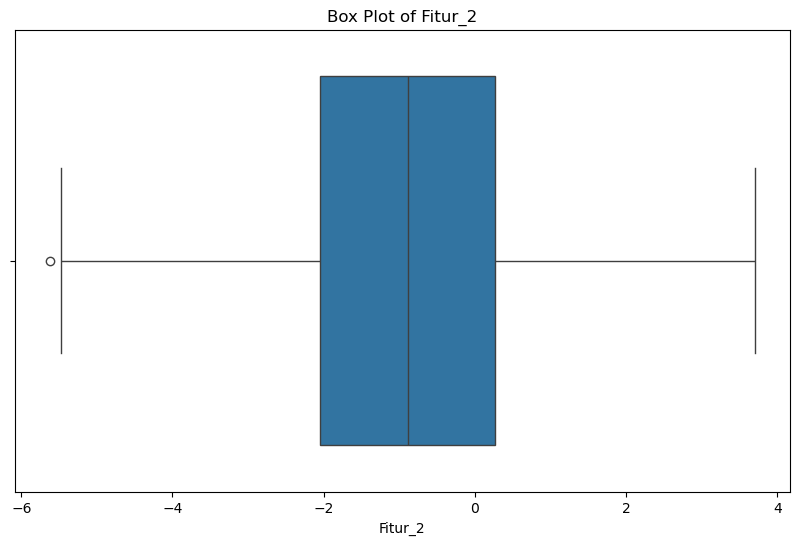

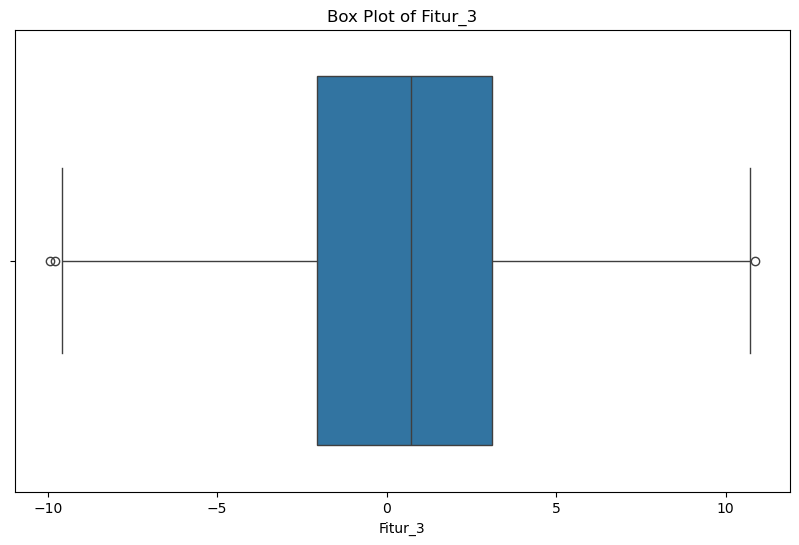

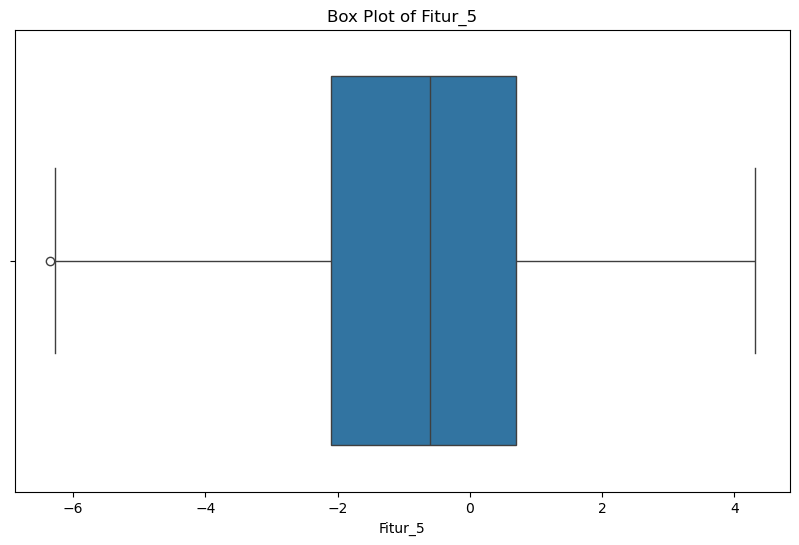

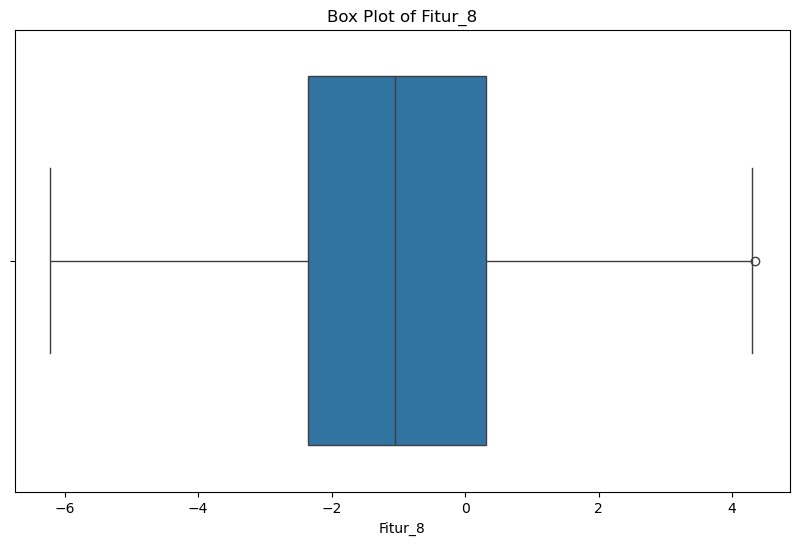

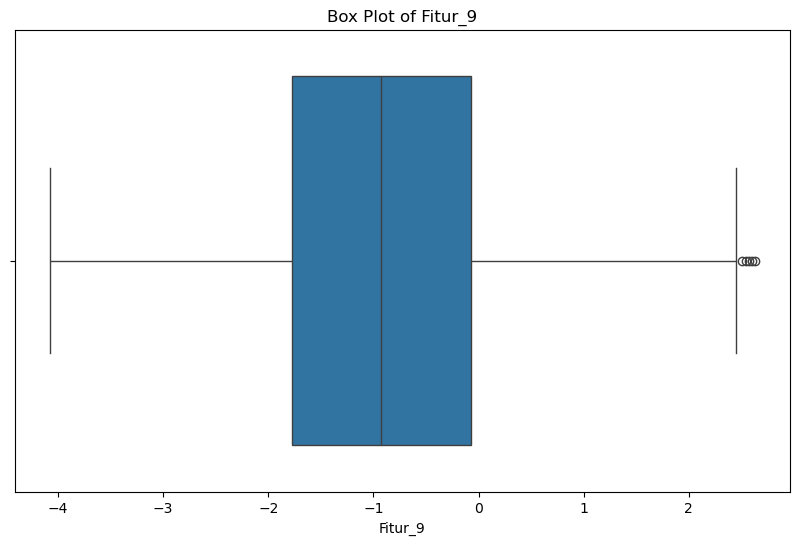

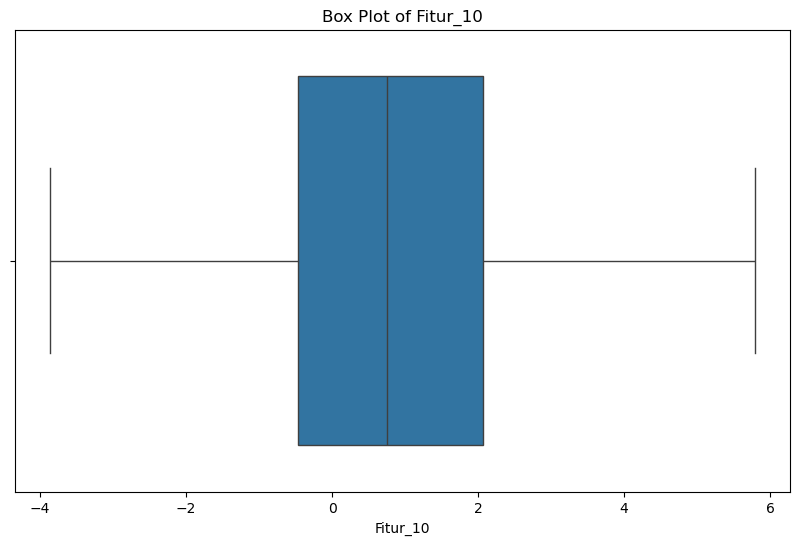

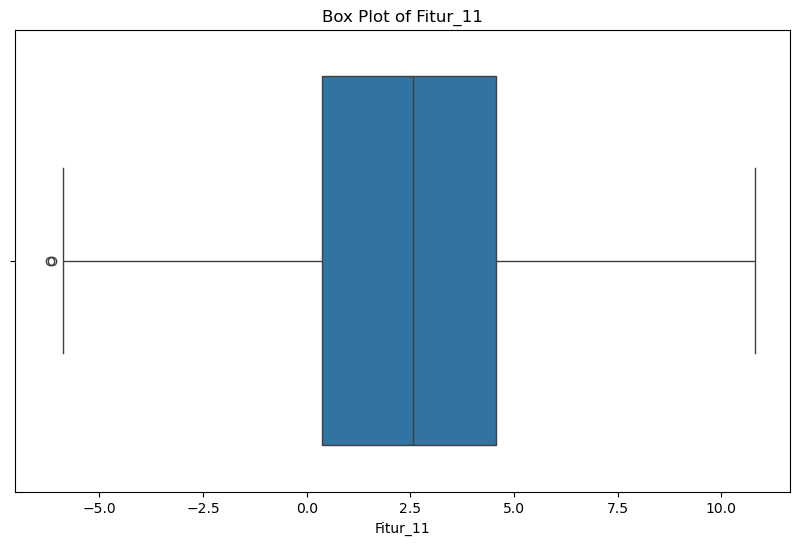

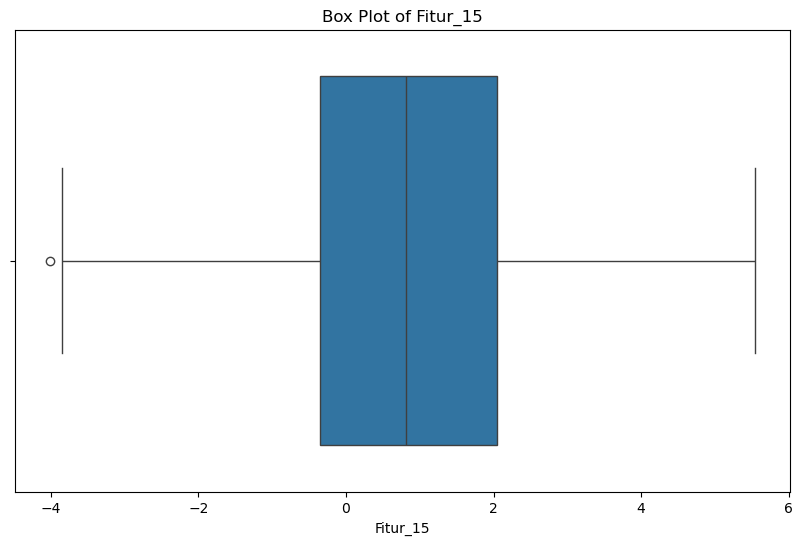

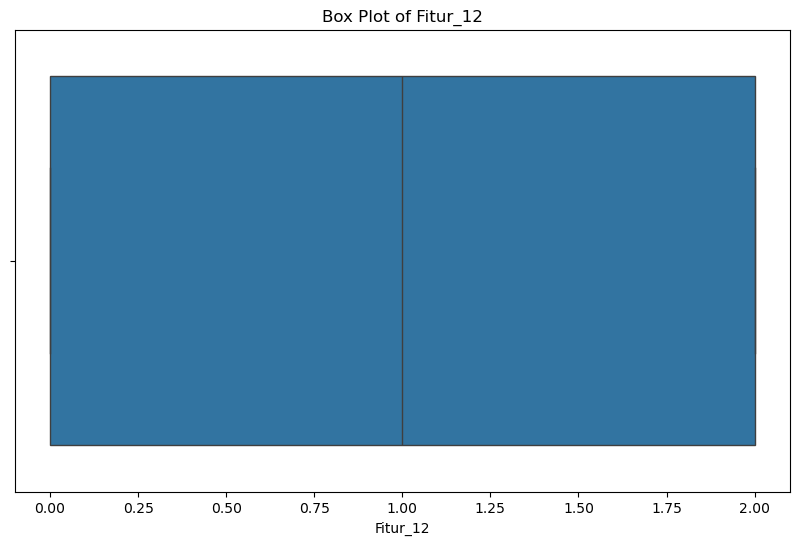

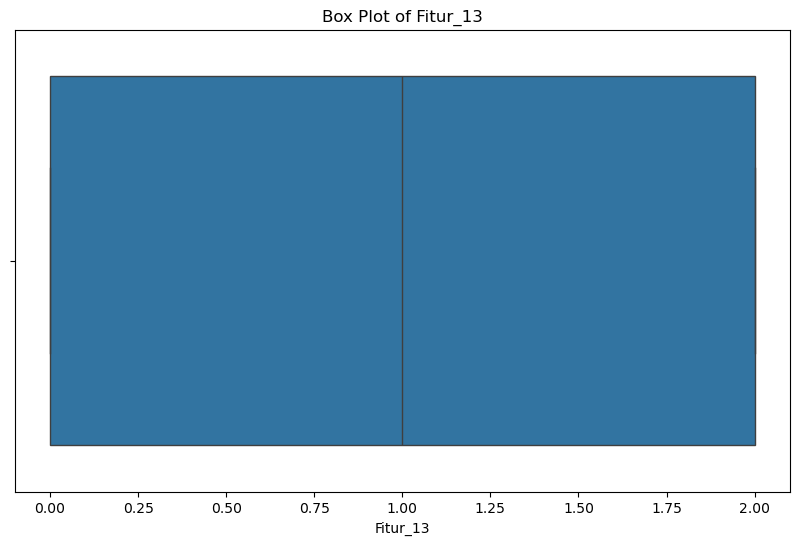

In [33]:
for feature in X_cleaned.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=X_cleaned[feature])
    plt.title(f'Box Plot of {feature}')
    plt.show()

In [28]:
X_cleaned

,Fitur_2,Fitur_3,Fitur_5,Fitur_8,Fitur_9,Fitur_10,Fitur_11,Fitur_15,Fitur_12,Fitur_13
0,-3.472520,-1.314199,0.642138,1.146301,-2.173112,2.765828,-1.821258,-0.276558,1,1
1,-1.770842,-1.578851,-2.025230,-3.958705,-0.598147,1.018789,4.194233,0.285979,2,1
2,-2.051770,3.631998,1.674093,0.031633,-1.140149,2.069694,1.935251,-2.867291,0,0
3,-1.608657,-0.735184,-1.753532,-2.897416,-0.830328,1.572469,5.334621,1.255376,1,2
4,-2.362885,-3.909120,-4.029843,-3.435229,-2.142380,2.332385,3.816539,2.810524,0,0
...,...,...,...,...,...,...,...,...,...,...
995,-0.017325,4.884411,3.033376,1.278882,-1.293396,1.772169,-1.191263,-2.629004,2,1
996,-1.690916,5.949207,2.238469,-1.436622,-2.153011,-0.867583,3.962758,-1.248408,2,2
997,-1.263417,-1.331925,1.777577,-1.846263,1.753033,1.858452,4.264568,0.931995,0,1
998,-0.975838,0.279144,-0.443749,-1.017319,-0.643070,2.142898,3.399255,0.800834,0,1


Jumlah data yang Anda miliki sekarang berjumlah 949 data, jumlah ini mungkin akan berbeda dengan latihan mandiri yang dilakukan karena menggunakan fungsi yang menghasilkan data berbeda. Setidaknya, Anda sudah mengetahui bahwa kode sebelumnya dapat menghilangkan outlier yang ada pada dataset.

Setelah berhasil menghilangkan outlier, mungkin Anda merasa bahwa dataset sudah siap untuk dilatih. Eits, sampai di sini, Anda belum melihat distribusi data. Karena data yang kita gunakan merupakan hasil randomize dari fungsi make_classification(), distribusi data yang dihasilkan belum tentu baik. Selain itu, terdapat permasalahan yang sudah kita tentukan sejak awal pembuatan dataset ini yaitu imbalance dataset. 

Seperti yang sudah Anda ketahui, kita sudah menentukan pembagian dataset pada pada kasus ini dengan proporsi 90-10, 90% untuk kelas pertama dan 10% untuk kelas kedua. Permasalahan ini perlu Anda selesaikan dengan melakukan oversampling atau undersampling sehingga dataset yang digunakan memiliki proporsi yang seimbang. 

Pada kasus ini, kita akan menggunakan teknik SMOTE yang sebelumnya sudah Anda pelajari pada materi Synthetic Minority Oversampling Technique. 

# SMOTE

### 1. Inisialisasi SMOTE

In [36]:
smote = SMOTE(random_state=42)

### 2. Melakukan Over Sampling pada dataset

In [37]:
X_resampled, y_resampled = smote.fit_resample(X_cleaned, y)

### 3. Menampilkan distribusi kelas setelah SMOTE

In [38]:
print("Distribusi kelas setelah SMOTE:", Counter(y_resampled))

Distribusi kelas setelah SMOTE: Counter({0: 875, 1: 875})


Seperti yang dapat Anda lihat, dataset yang digunakan sudah memiliki proporsi yang seimbang ditandai dengan kedua kelas memiliki jumlah yang sama yaitu 875 data. Selanjutnya, Anda perlu mengecek distribusi data dari kedua kelas tersebut agar dapat mengidentifikasi distribusi data dengan lebih baik. 

Pada latihan kali ini, Anda dapat menggunakan kode berikut untuk membuat visualisasi distribusi data.

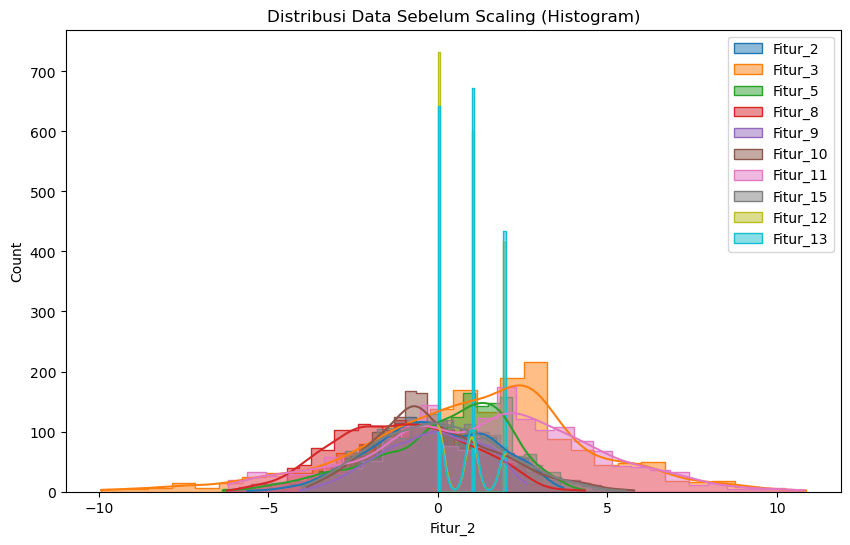

In [40]:
# 1. Visualisasi distribusi data sebelum scaling menggunakan histogram
plt.figure(figsize=(10, 6))
for col in X_resampled.columns:
    sns.histplot(X_resampled[col], kde=True, label=col, bins=30, element='step')
plt.title('Distribusi Data Sebelum Scaling (Histogram)')
plt.legend()
plt.show()

Ternyata distribusi data yang dihasilkan memiliki rentang yang berbeda-beda. Hal ini akan menjadi sebuah masalah karena masing-masing fitur memiliki skala yang berbeda juga. Untuk mengatasi permasalahan tersebut, Anda dapat menggunakan scaling fitur seperti normalisasi atau standardisasi agar distribusi data menjadi lebih baik. Pada kesempatan kali ini, kita akan menggunakan standardisasi agar skala data memiliki skala yang sama serta standar deviasi mendekati satu.

In [41]:
# Scaling: Standarisasi fitur numerik menggunakan StandardScaler
scaler = StandardScaler()
 
# Melakukan scaling pada fitur penting
X_resampled[important_features] = scaler.fit_transform(X_resampled[important_features])

Setelah Anda melakukan standardisasi seharusnya distribusi data menjadi lebih baik. Untuk melihat perbedaannya, mari kita buat sebuah visualisasi seperti sebelumnya agar dapat melakukan perbandingan.

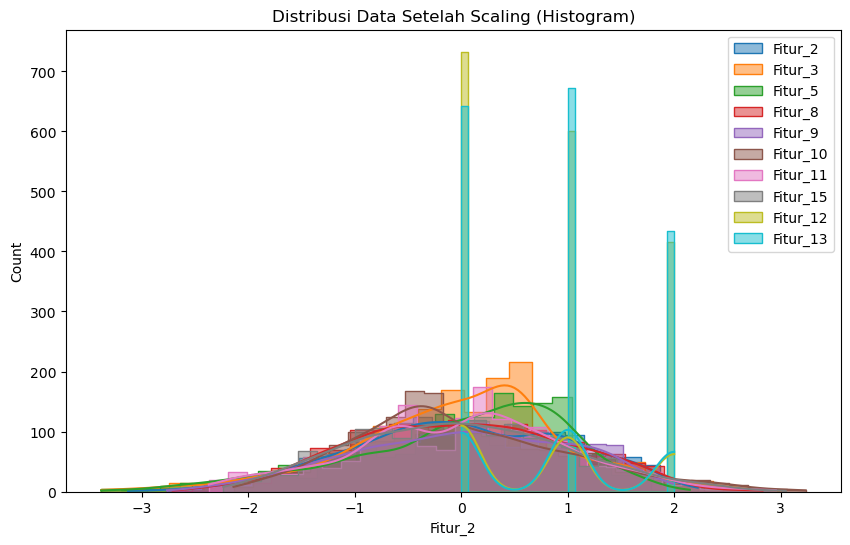

In [42]:
# 1. Visualisasi distribusi data setelah scaling menggunakan histogram
plt.figure(figsize=(10, 6))
for col in X_resampled.columns:
    sns.histplot(X_resampled[col], kde=True, label=col, bins=30, element='step')
plt.title('Distribusi Data Setelah Scaling (Histogram)')
plt.legend()
plt.show()

Sampai di sini sudah sangat terlihat ‘kan perbedaannya? Untuk memastikan kembali standardisasi dilakukan dengan baik, silakan Anda gunakan kode berikut untuk melihat karakteristik data dengan lebih detail.

In [43]:
X_resampled.describe(include='all')

,Fitur_2,Fitur_3,Fitur_5,Fitur_8,Fitur_9,Fitur_10,Fitur_11,Fitur_15,Fitur_12,Fitur_13
count,1.750000e+03,1750.000000,1750.000000,1.750000e+03,1.750000e+03,1750.000000,1.750000e+03,1750.000000,1750.000000,1750.000000
mean,6.496391e-17,0.000000,0.000000,4.567775e-17,-3.248195e-17,0.000000,-3.248195e-17,0.000000,0.818857,0.880571
std,1.000286e+00,1.000286,1.000286,1.000286e+00,1.000286e+00,1.000286,1.000286e+00,1.000286,0.790010,0.775570
min,-3.131113e+00,-3.382050,-3.384300,-2.712491e+00,-2.765490e+00,-2.140294,-2.372372e+00,-2.236094,0.000000,0.000000
25%,-6.899013e-01,-0.601627,-0.587805,-7.302132e-01,-7.403407e-01,-0.696135,-6.501038e-01,-0.757607,0.000000,0.000000
50%,-2.398047e-03,0.059088,0.200181,-1.932975e-03,5.164078e-02,-0.177215,8.466122e-02,-0.025270,1.000000,1.000000
75%,7.850095e-01,0.569903,0.745362,7.238644e-01,8.104621e-01,0.639702,6.701172e-01,0.703264,1.000000,1.000000
max,2.220876e+00,3.002218,2.146499,2.829761e+00,1.991819e+00,3.235474,2.954645e+00,3.045974,2.000000,2.000000


Seluruh fitur yang ada kini sudah memiliki rentang yang serupa dan memiliki standar deviasi mendekati satu. Hal ini berarti proses standardisasi yang Anda lakukan sudah berjalan dengan baik.

